## --------------------------- FINAL CONDENSED CODE ------------------------------

## Step 1.a: Data Importing and Preprocessing

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor


Import Data

In [ ]:
# Path for PC --- Uncomment out depending on device
# df3 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2023.csv')


# Path for Laptop
data = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2023.csv')


C:\Users\oakle\AppData\Local\Temp\ipykernel_18092\363168435.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2023.csv')


In [97]:
# print starting data
data

,StudyYear,PivotPlanCode,ParIndicator,Ratebook,CvgStatus,IssueState,CvgFace,CvgOrigFace,CvgPrevFace,UWAmount,...,2015vbtCompositeExpNum,SizeGroup,AgeRange,DurationRange,UWAge,UWDuration,ConversionIndicator,2015vbtExpAmtConv,2015vbtExpNumtConv,ClaimsDeathCode
0,2023,LD1460,Y,6,1,MS,100000.0,100000.0,100000.0,100000.0,...,0.0141,"$100,000 - $249,999",40-49,16+,43,29,N,1410.0000,0.0141,NaN
1,2023,LD1460,Y,6,1,MS,40000.0,40000.0,40000.0,40000.0,...,0.0047,"$25,000 - $49,999",30-39,16+,30,29,N,188.4000,0.0047,NaN
2,2023,LD1460,Y,6,2,NC,85000.0,85000.0,85000.0,85000.0,...,0.0042,"$50,000 - $99,999",20-29,16+,29,29,N,364.6500,0.0042,NaN
3,2023,LD1460,Y,6,B,MS,40000.0,40000.0,40000.0,40000.0,...,0.0040,"$25,000 - $49,999",30-39,16+,31,29,N,160.4000,0.0040,NaN
4,2023,LD1460,Y,6,E,NC,71000.0,71000.0,71000.0,71000.0,...,0.0009,"$50,000 - $99,999",20-29,16+,29,30,N,64.4325,0.0009,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857302,2023,UV1080,N,8,E,TX,100000.0,100000.0,100000.0,100000.0,...,0.0049,"$100,000 - $249,999",40-49,15-Nov,45,15,N,340.0000,0.0034,NaN
857303,2023,UVI070,N,7,1,AR,100000.0,100000.0,100000.0,100000.0,...,0.0000,"$100,000 - $249,999",20-29,16+,26,19,N,111.0000,0.0000,NaN
857304,2023,UVI070,N,7,1,NC,250000.0,250000.0,250000.0,250000.0,...,0.0000,"$250,000 - $499,999",20-29,16+,26,18,N,265.0000,0.0000,NaN
857305,2023,UVI070,N,7,1,NC,350000.0,350000.0,350000.0,350000.0,...,0.0000,"$250,000 - $499,999",30-39,16+,36,16,N,1456.0000,0.0000,NaN


Data Preprocessing

In [98]:
# Define X variable
df = data[['CvgSexCode',
        'CvgIssueAge',
        'Duration',
        'AttainedAge',
        'UWClass',
        'SubstandardIndicator',
        '2015vbtExpAmt',
        '2015vbtExpNum',
        'MortExposureAmt',
        'MortExposureNum',
        'MortDecAmt'
        ]]

# Remove duplicates
df = df.drop_duplicates()

# Remove Empty Values
df = df.dropna()

df = df[df['SubstandardIndicator'] == 'N']

# Create a 'PayoutOccurred' binary column (1 for payout, 0 for no payout)
df['PayoutOccurred'] = (df['MortDecAmt'] > 0 ).astype(int)

df.reset_index(inplace=True,drop=True)

# Convert sex code to binary
df['IsMale'] = np.where(df['CvgSexCode'] == 'M', 1, 0)

# Convert UnderWritingClass to Dummies
UWClass_dummies = pd.get_dummies(data=df['UWClass'],dtype=int)
UWClass_dummies

# Remove old columns that have been converted to binary values or removed
df = df.drop(columns=['CvgSexCode','SubstandardIndicator','UWClass'])
df = pd.concat([df,UWClass_dummies],axis =1)


# Group age into groups of 5
# Define the age intervals
bins = [0,
        20,
        25,
        30,
        35,
        40,
        45,
        50,
        55,
        60,
        65,
        70,
        75,
        80,
        110
        ] # Up to 70+ group

# Create group labels from age bins (Convert to a list of ints 1, 2, ..., n)
num_groups = len(bins) - 1
labels = list(range(num_groups))

# Categorize ages using pd.cut
df['AttainedAge'] = pd.cut(df['AttainedAge'], bins=bins, labels=labels, right=False)
df = df.fillna(0)
df['AttainedAge'] = df['AttainedAge'].astype(int)

# Categorize Duration into q 'Quartiles' for better accuracy
df['Duration'] = pd.qcut(df['Duration'],
                         q=10,
                         labels=range(0,10))
df['Duration'] = df['Duration'].astype(int)

# Get only the rows that are of UWClass 'PT', 'PN', 'SP', 'SN', or 'ST'
df = df[df[['PT', 'PN', 'SP', 'SN', 'ST']].eq(1).any(axis=1)]

# Rearrage the collumns to look better and be more funtional
df = df.reindex(['IsMale','Duration','CvgIssueAge','AttainedAge','MortExposureAmt','MortExposureNum','2015vbtExpAmt','2015vbtExpNum','PN','PT','SP','ST','SN','PayoutOccurred'],axis =1)

# Initial train-test split 40% test, 60% train
train_data, test_data = train_test_split(df, test_size=0.4, random_state=42,stratify=df['PayoutOccurred'])

train_data

,IsMale,Duration,CvgIssueAge,AttainedAge,MortExposureAmt,MortExposureNum,2015vbtExpAmt,2015vbtExpNum,PN,PT,SP,ST,SN,PayoutOccurred
331976,1,6,38,8,125000.000000,1.0000,773.750000,0.0061,0,0,0,1,0,0
292454,1,0,31,3,75219.520000,1.0000,11.282928,0.0001,0,0,1,0,0,0
302264,0,1,26,3,303178.600000,2.0000,51.540362,0.0002,0,0,0,0,1,0
146538,0,5,4,0,8931.526693,0.3333,2.411512,0.0000,0,0,0,0,1,0
142168,1,5,42,7,83381.050000,3.0000,162.593048,0.0057,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337723,0,6,32,6,250000.000000,1.0000,567.500000,0.0022,0,0,0,1,0,0
352414,1,5,54,10,416666.666700,0.4166,2633.333333,0.0026,1,0,0,0,0,0
104149,1,6,24,5,106545.800000,1.0000,89.498472,0.0008,0,0,1,0,0,0
138419,1,5,37,6,26173.960000,1.0000,32.193971,0.0012,0,0,0,0,1,0


## Step 1.b: Data Aggregation

In [99]:
# Step 2: Aggregation Function
def aggregate_data(df):

    grouped = df.groupby(['IsMale', 'Duration', 'AttainedAge','PN','PT','SP','ST','SN']).agg(
        AvgPolicyAmt=('MortExposureAmt', 'mean'),
        AvgExpAmt=('2015vbtExpAmt','mean'),
        AvgExpNum=('2015vbtExpNum','mean'),
        AvgIssueAge=('CvgIssueAge','mean'),
        PayoutOccurrenceRate=('PayoutOccurred', 'mean')
    ).reset_index().dropna()
    return grouped

# Aggregating train and test sets separately
train_agg = aggregate_data(train_data)
test_agg = aggregate_data(test_data)

In [100]:
# print train data
train_agg

,IsMale,Duration,AttainedAge,PN,PT,SP,ST,SN,AvgPolicyAmt,AvgExpAmt,AvgExpNum,AvgIssueAge,PayoutOccurrenceRate
0,0,0,0,0,0,0,0,1,241054.291115,29.375238,0.000291,7.636667,0.000556
1,0,0,0,0,0,0,1,0,100682.213939,26.726508,0.000157,18.159091,0.000000
2,0,0,0,0,0,1,0,0,349645.718086,93.101579,0.000243,18.370370,0.000000
3,0,0,0,0,1,0,0,0,175000.000000,46.333333,0.000133,18.666667,0.000000
4,0,0,0,1,0,0,0,0,164865.203536,44.158592,0.000208,18.306122,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,1,8,10,1,0,0,0,0,165927.746377,1432.614801,0.008972,40.347826,0.000000
948,1,8,11,0,0,0,0,1,69393.527778,1138.410853,0.017567,46.555556,0.000000
949,1,8,11,0,0,0,1,0,48333.333333,1887.866667,0.039000,47.666667,0.000000
950,1,8,12,0,0,0,0,1,85235.005000,1916.082913,0.022400,48.500000,0.000000


In [101]:
# # Create Classification Labels for Train/Test after Aggregation
y_train = train_agg['PayoutOccurrenceRate']
y_test = test_agg['PayoutOccurrenceRate']


X_train = train_agg.drop('PayoutOccurrenceRate',axis=1)
X_test = test_agg.drop('PayoutOccurrenceRate',axis=1)

## Step 2.a: Feature Evaluation Using Collinearity Maxtrix

In [102]:
# ------------------------------------------------ Check Collinearity to rule out variables --------------------------------------------

# If num > .90 , Column x Row are collinear
X_train= pd.DataFrame(X_train)

# Put Y infront of X variables
Xy_collin = pd.concat([y_train, X_train],axis = 1)

# Create collinearity matrix using pearson method
corr_m = Xy_collin.corr(method='pearson')

# Absolute value the matrix
corr_m_abs = corr_m.abs()

# Take only the upper right triangle of the matrix since it is symetrical along that line
corr_m_upper = corr_m_abs.where(
    np.triu(np.ones(corr_m_abs.shape), k=1).astype(bool))

# Convert to boolean where values > .9 are 1, everything else is 0
where_collinear = corr_m_upper > .9
where_collinear.where(
    np.triu(np.ones(where_collinear.shape), k=1).astype(bool)).fillna(0).astype(int)

C:\Users\oakle\AppData\Local\Temp\ipykernel_18092\204418210.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  np.triu(np.ones(where_collinear.shape), k=1).astype(bool)).fillna(0).astype(int)


,PayoutOccurrenceRate,IsMale,Duration,AttainedAge,PN,PT,SP,ST,SN,AvgPolicyAmt,AvgExpAmt,AvgExpNum,AvgIssueAge
PayoutOccurrenceRate,0,0,0,0,0,0,0,0,0,0,0,0,0
IsMale,0,0,0,0,0,0,0,0,0,0,0,0,0
Duration,0,0,0,0,0,0,0,0,0,0,0,0,0
AttainedAge,0,0,0,0,0,0,0,0,0,0,0,0,1
PN,0,0,0,0,0,0,0,0,0,0,0,0,0
PT,0,0,0,0,0,0,0,0,0,0,0,0,0
SP,0,0,0,0,0,0,0,0,0,0,0,0,0
ST,0,0,0,0,0,0,0,0,0,0,0,0,0
SN,0,0,0,0,0,0,0,0,0,0,0,0,0
AvgPolicyAmt,0,0,0,0,0,0,0,0,0,0,0,0,0


Remove the AvgIssue Age due to Collinearity

In [103]:
#Remove AvgIssueAge column since it is colinear with attained age category
X_train = X_train.drop('AvgIssueAge',axis=1)
X_test = X_test.drop('AvgIssueAge',axis=1)
X_test

,IsMale,Duration,AttainedAge,PN,PT,SP,ST,SN,AvgPolicyAmt,AvgExpAmt,AvgExpNum
0,0,0,0,0,0,0,0,1,207947.122775,25.239166,0.000206
1,0,0,0,0,0,0,1,0,100551.341868,27.082442,0.000128
2,0,0,0,0,0,1,0,0,441742.039502,117.796053,0.000223
3,0,0,0,0,1,0,0,0,208333.333333,54.166667,0.000067
4,0,0,0,1,0,0,0,0,206008.900800,54.675737,0.000192
...,...,...,...,...,...,...,...,...,...,...,...
926,1,8,10,1,0,0,0,0,123825.757576,1141.649242,0.009895
927,1,8,11,0,0,0,0,1,66791.552222,1185.619533,0.019622
928,1,8,11,0,0,0,1,0,66666.666670,2140.666667,0.026700
929,1,8,12,0,0,0,0,1,60000.000000,1519.200000,0.025300


## Illustration of XGBRegressor

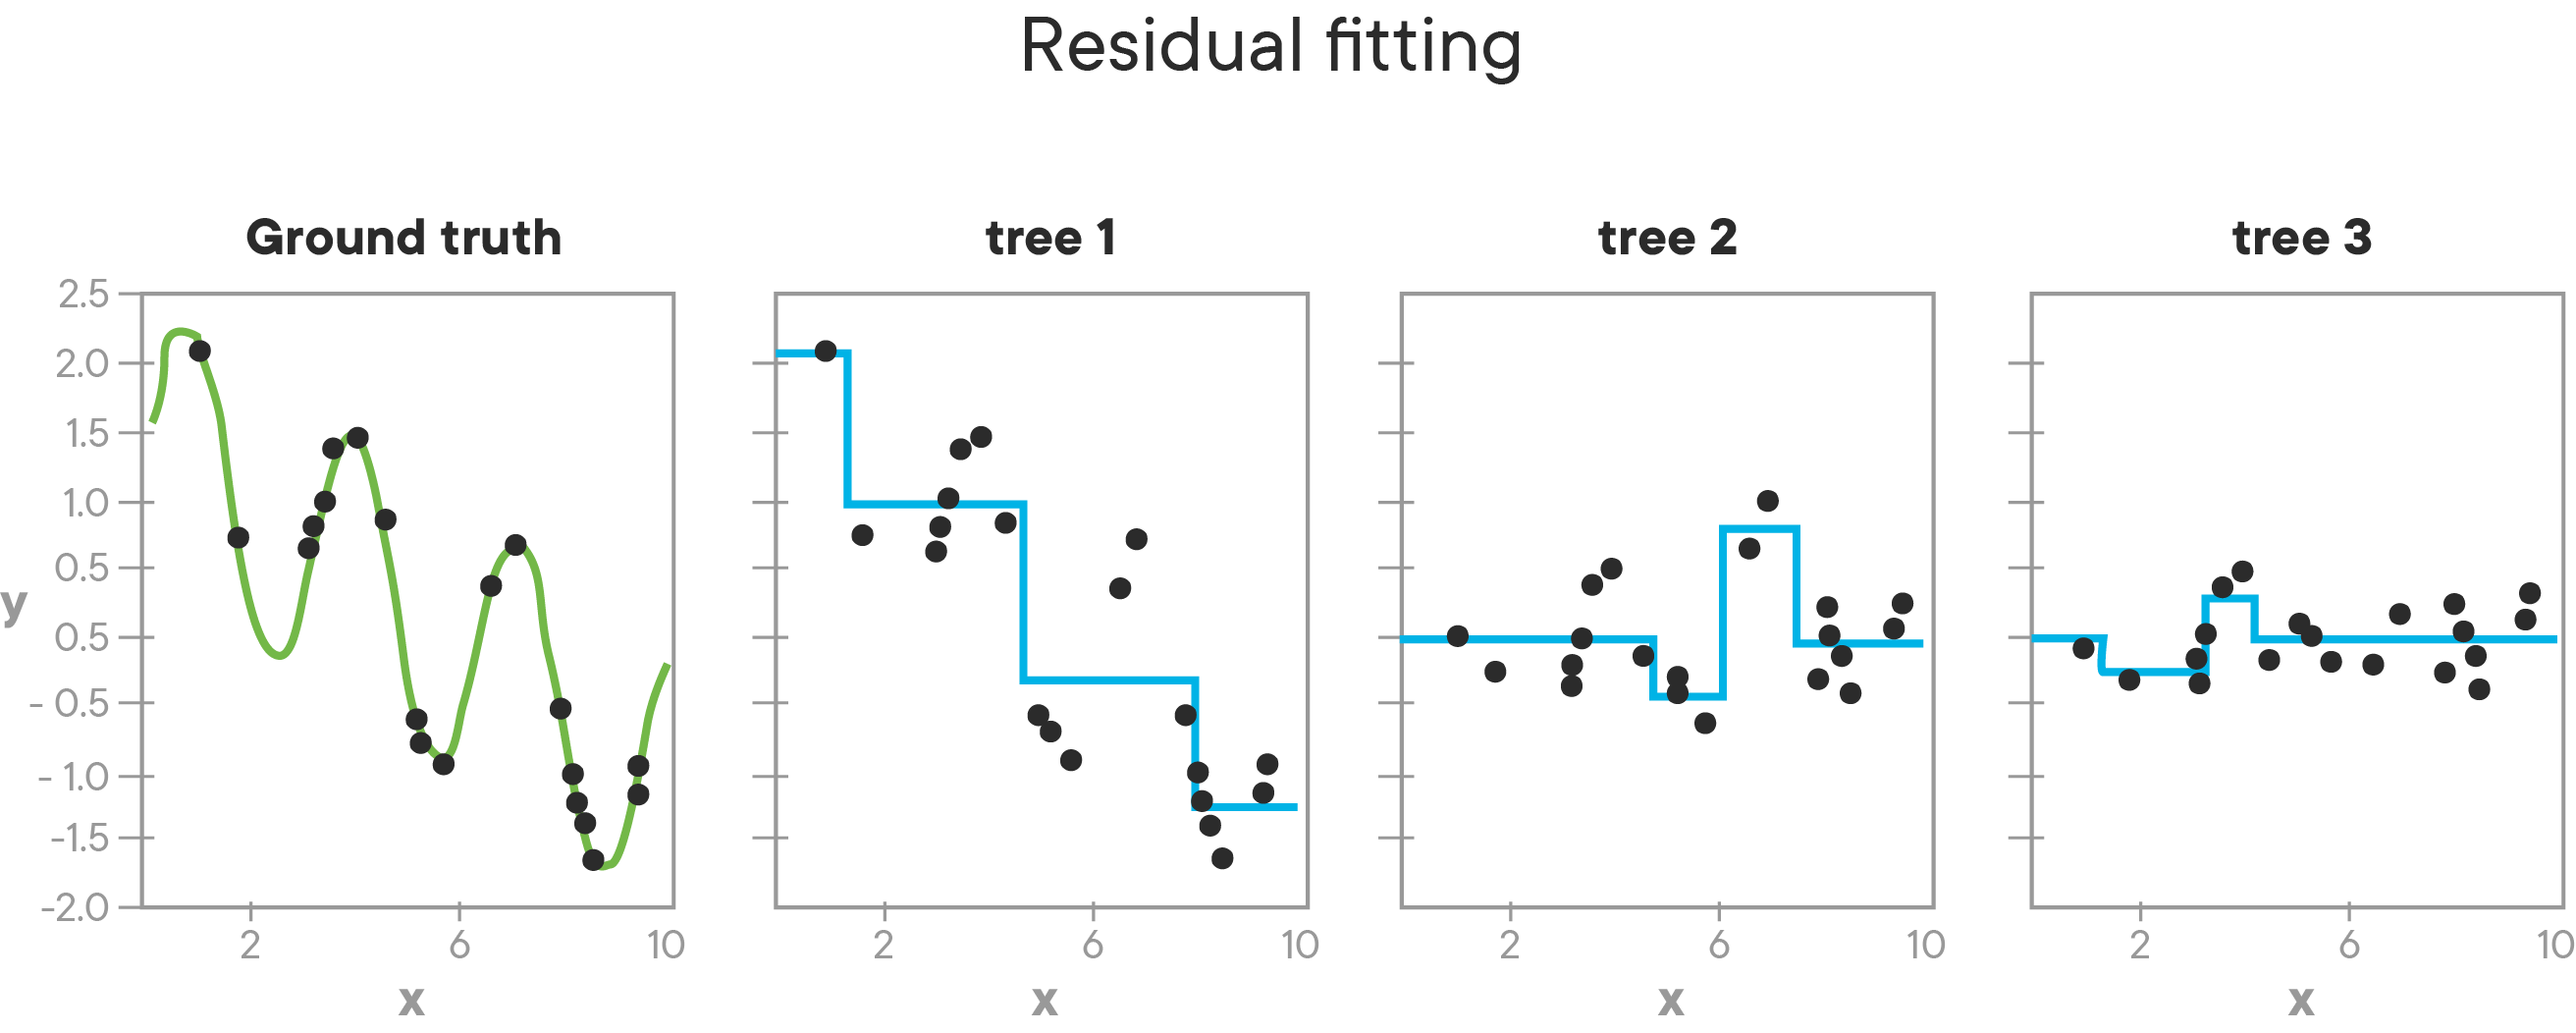

Reference: https://github.com/learn-co-curriculum/dsc-gradient-boosting-and-weak-learners/blob/master/index.ipynb

* Gradient boosting starts with a weak learner that makes predictions on the dataset. The algorithm then checks this learner's performance, identifying examples that it got right and wrong.
* The model then calculates the **residuals** for each data point, to determine how far off the mark each prediction was.
* The model then combines these residuals with a **loss function** to calculate the overall loss. There are many loss functions that are used -- the thing that matters most is that the loss function is **differentiable** so that we can use calculus to compute the **gradient for the loss**, given the inputs of the model.
* We then use the gradients and the loss as predictors to train the next tree. In this way, we can use Gradient Descent to minimize the overall loss.

Since the loss is most heavily inflated by examples where the model was wrong, gradient descent will push the algorithm towards creating a new learner that will focus on these harder examples. If the next tree gets these right, then the loss goes down! In this way, gradient descent allows us to continually train and improve on the loss for each model to improve the overall performance of the ensemble as a whole by focusing on the "hard" examples that cause the loss to be high.

In [104]:
# Define the Plot and regress method
def plot_and_measure_regression(model_name :str , y_pred, y_true):

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    y_pred_sorted = np.sort(y_pred, axis=0)
    y_true_sorted = np.sort(y_true, axis=0)

    plt.figure
    plt.plot(y_pred_sorted, color = 'Blue', label = 'OP_Model')
    plt.plot(y_true_sorted, color = 'Orange', label = 'Historical Data')
    plt.title(f'{model_name} Regression Chart')
    plt.xlabel('Sorted Index (meaningless)')
    plt.legend()
    plt.ylabel('Avg Mortality Probabilty')
    plt.show()


# Define Expected vs Predicted graph function
def exp_vs_pred(model_name :str, y_pred, y_true):

    plt.scatter(x= y_true, y= y_pred, color = 'Blue')
    plt.axline(xy1=(0,0), slope= 1, color = 'Orange',label = 'Ideal Line')
    plt.title(f'{model_name} Actual vs Predicted')
    plt.legend()
    plt.xlabel('y_true')
    plt.xlim((0,.1))
    plt.ylabel('y_pred')
    plt.ylim((0,.1))
    plt.show()



## Step 3.a: Model Training and Evaluation

Memorization Metrics: 
Mean Squared Error: 2.0454835603293262e-06
Mean Absolute Error: 0.000989302704335639
R2 Score:  0.99921321177586
Total Difference:  0.0735178

Generalization metrics: 
Mean Squared Error: 0.004407382782715693
Mean Absolute Error: 0.01429342598700532
R2 Score:  -0.4294902220508501
Total Difference:  0.22850037


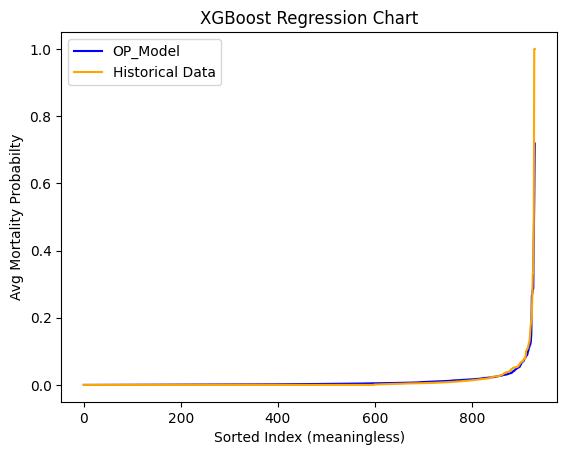

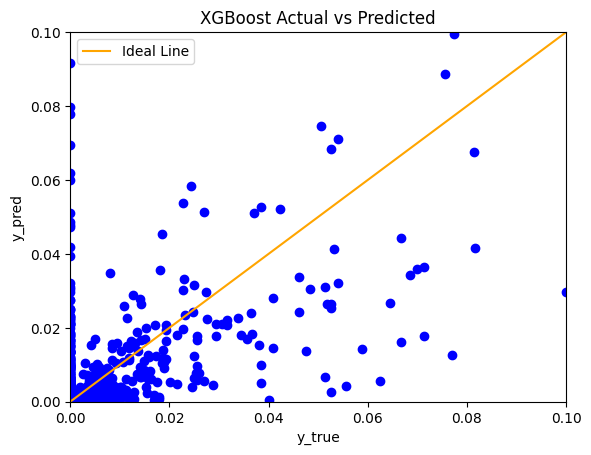

In [105]:

# Step 3: Train Regression Model 

model = XGBRegressor()  # Define Regression model

#train on non-smote data
model.fit(X_train, y_train)

# Regression predictions on train set (Memorization)
y_pred_train = abs(model.predict(X_train))
mse = mean_squared_error(y_train, y_pred_train)
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train,y_pred_train)
avgDiff = sum(y_pred_train) - sum(y_train)
print("Memorization Metrics: ")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score: ", r2)
print("Total Difference: ",avgDiff)
print()

# Regression predictions on test set (Generalization)
y_pred = abs(model.predict(X_test))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test,y_pred)
avgDiff = sum(y_pred) - sum(y_test)
print("Generalization metrics: ")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score: ", r2)
print("Total Difference: ",avgDiff)

# # Plot the importance of each variable
# xgb.plot_importance(model, importance_type='gain')

plot_and_measure_regression(model_name='XGBoost',
                            y_pred=y_pred,
                            y_true=y_test
                            )

exp_vs_pred(model_name='XGBoost',
            y_pred=y_pred,
            y_true=y_test
            )



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

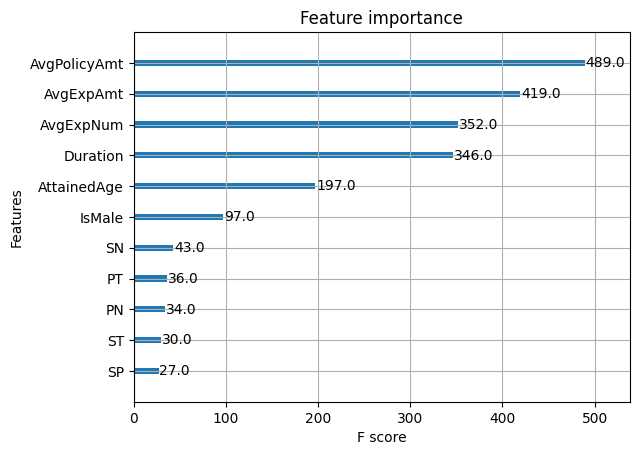

In [106]:
# Plot how important each variable is to the model
xgb.plot_importance(model)

## Step 3.b: Model Crossvalidation and Optimization

In [107]:
# ------------- Use Crossvalidation to train better model ------------

# Define params for crossvalidation
params = {
    'learning_rate': [0.3, 0.1, 0.05],
    'max_depth': [3, 4],
    'subsample': [0.8, 0.9],
    'n_estimators': [20, 35, 50],
    'reg_lambda': [0.1, 0.05],
}

# This function will iterate through the parameters listed above and find the best combination 
# while also for each model perform a K fold (k = cv variable) cross validation to hopefully get more accurate results
model_cv = GridSearchCV(
    model,
    param_grid= params,
    cv=5
)

# Train crossvalidation model on smote train data
model_cv.fit(X_train,y_train)

# Print best params
print(model_cv.best_params_)


{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 20, 'reg_lambda': 0.05, 'subsample': 0.8}


Memorization Metrics: 
Mean Squared Error: 0.0006814657436382616
Mean Absolute Error: 0.009628039633219648
R2 Score:  0.7378765429124012
Total Difference:  0.0690794

Generalization metrics: 
Mean Squared Error: 0.0029773130381431584
Mean Absolute Error: 0.01371273899428065
R2 Score:  0.034338498416578433
Total Difference:  -0.86199


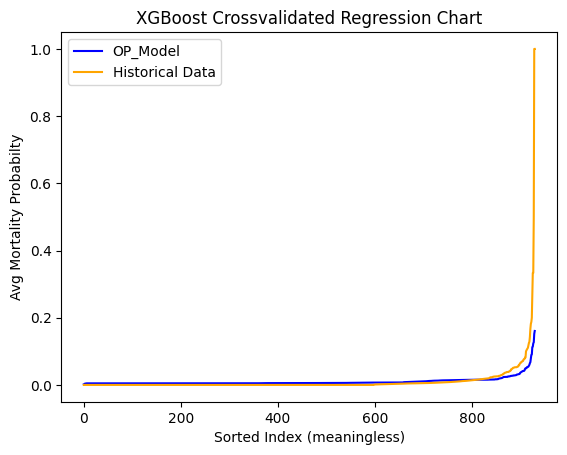

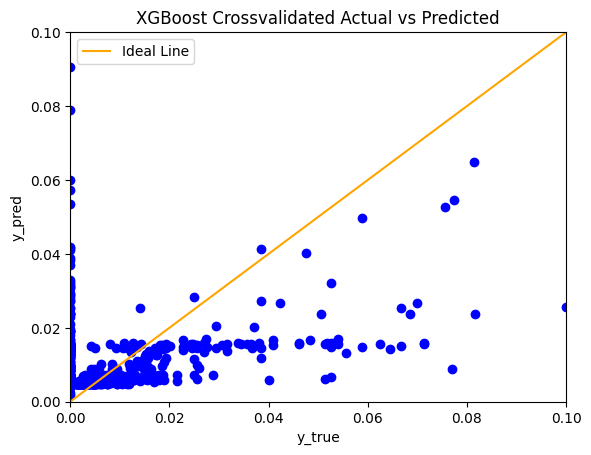

In [108]:
# Regression predictions on train set (Memorization)
y_pred_train_cv = abs(model_cv.predict(X_train))
mse = mean_squared_error(y_train, y_pred_train_cv)
mae = mean_absolute_error(y_train, y_pred_train_cv)
r2 = r2_score(y_train,y_pred_train_cv)
avgDiff = sum(y_pred_train_cv) - sum(y_train)
print("Memorization Metrics: ")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score: ", r2)
print("Total Difference: ",avgDiff)
print()

# Regression predictions on test set (Generalization)
y_pred_cv = abs(model_cv.predict(X_test))
mse = mean_squared_error(y_test, y_pred_cv)
mae = mean_absolute_error(y_test, y_pred_cv)
r2 = r2_score(y_test,y_pred_cv)
avgDiff = sum(y_pred_cv) - sum(y_test)
print("Generalization metrics: ")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score: ", r2)
print("Total Difference: ",avgDiff)

plot_and_measure_regression(model_name='XGBoost Crossvalidated',
                            y_pred=y_pred_cv,
                            y_true=y_test
                            )

exp_vs_pred(model_name='XGBoost Crossvalidated',
            y_pred=y_pred_cv,
            y_true=y_test
            )


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

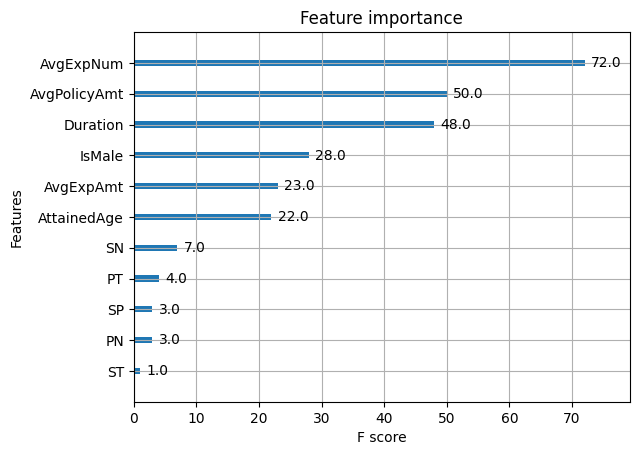

In [109]:
xgb.plot_importance(model_cv.best_estimator_)

## Step 4: Final Model Results

Ultimately, it was determined that for the use case of life insurance, the non-crossvalidated model was a more beneficial. The exact reason that led to this determination is the inconsistency shown in the CV model, specifically in the first non-zero values (See XGBoost_CV regression chart). In the case of life insurance it is better to slightly over estimate the probability of a death rather than under estimate. Likewise, this was another reason the non-crossvalidated model was chosen. The total difference was a negative value, indicating that it's estimations were below the 2023 mortality probability values.

[Exact metrics can be seen in the section above]

In [ ]:
# Convert data to compatible form for saving to Excel
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
y_pred = pd.DataFrame(y_pred,columns=['OP_Model_Preds'])
final_data = pd.concat([X_test,y_test,y_pred],axis =1 )
final_data

# Note: probability values are n/1000 
# e.g .000247 out of 1000 people so true value is .000000247 probability of mortality

# ----------------------------------
# Key for Under Writing Classes:
# PN = 'Preferred Non-Tobacco'
# PT = 'Preferred Tobacco'
# SP = 'Super-Preferred Non-Tobacco'
# ST = 'Standard Tobacco'
# SN = 'Standard Non-Tobacco'

# -------------------------------------------------------------
# AvgExpNum = The avg 2015vbtExpNum for the category (row)
# PayoutOccurrenceRate = the percent of payouts/deaths for that category(row)
# OP_Model_Preds = Our model's predictions for payout occurrence rate per category(row)

,IsMale,Duration,AttainedAge,PN,PT,SP,ST,SN,AvgPolicyAmt,AvgExpAmt,AvgExpNum,PayoutOccurrenceRate,OP_Model_Preds
0,0,0,0,0,0,0,0,1,207947.122775,25.239166,0.000206,0.0,0.000992
1,0,0,0,0,0,0,1,0,100551.341868,27.082442,0.000128,0.0,0.000346
2,0,0,0,0,0,1,0,0,441742.039502,117.796053,0.000223,0.0,0.000008
3,0,0,0,0,1,0,0,0,208333.333333,54.166667,0.000067,0.0,0.000438
4,0,0,0,1,0,0,0,0,206008.900800,54.675737,0.000192,0.0,0.000038
...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,1,8,10,1,0,0,0,0,123825.757576,1141.649242,0.009895,0.0,0.015594
927,1,8,11,0,0,0,0,1,66791.552222,1185.619533,0.019622,0.0,0.023130
928,1,8,11,0,0,0,1,0,66666.666670,2140.666667,0.026700,0.0,0.024979
929,1,8,12,0,0,0,0,1,60000.000000,1519.200000,0.025300,0.0,0.009682


In [111]:
# Save final model predictions to an excel file for futher analysis

final_data.to_excel('final_data.xlsx')

## Step 5: Analysis of Model Baises and Insufficifencies 

After the model was successfully trained the final probability predictions were compared to both the average 2015vbtExpNum for each category and the true rate of mortality from the 2023 dataset.